In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
def linear_costs(x, y, z, theta):
    costs = (np.matmul(x,theta)-z)*(1-2*y)
    return costs

In [3]:
def paired_classifier(x, costs):
    f = []
    for cost in costs.T:
        f.append(LinearRegression().fit(x, cost))
    return f

In [4]:
def obj_grad(objective, x, z, theta, n):
    if objective=='MSE':
        grad = (2/n)*np.matmul(x.T,np.matmul(x,theta)-z)
        return grad.flatten()
    elif objective=='dot_product':
        grad = (1/n)*np.matmul(x.T,z)
        return grad.flatten()
    else:
        return 0

In [5]:
def linear_proxies(x, y, z_all, C, iters, n, K, objective=None):
    theta_list = []
    for k in range(0,K):
        z = z_all[:,k].reshape(-1,1)
        zhat = LinearRegression().fit(x, z)
        theta = [np.transpose(zhat.coef_)]
        grad_l = []
        for t in range(1, iters):
            costs = linear_costs(x, y, z, theta[t-1])
            f_s = paired_classifier(x, costs)
            val = []
            h= [0]*n
            for i, f in enumerate(f_s):
                h_s = f.predict(x)
                h[i] = h_s < 0
                val.append(np.sum(h_s[h[i]]))
            y_index = np.argmin(val)
            y_temp = y[:,y_index]
            h = h[y_index].astype(int)
            if np.abs(np.sum(np.matmul(x,theta[t-1]))/np.sum(z) - 1) >= np.abs(np.matmul((np.matmul(x,theta[t-1])-z).T,np.abs(h-y_temp))):
                penalty = np.sign(np.sum(np.matmul(x,theta[t-1]))/np.sum(z) - 1) * np.sum(x, axis=0)/np.sum(z)
            else:
                penalty = -np.sign(np.matmul(np.transpose(np.matmul(x,theta[t-1])-z),np.abs(h-y_temp))) * np.matmul(np.transpose(x),np.abs(h-y_temp))  
                penalty = penalty.flatten()
            grad_l.append(obj_grad(objective,x,z,theta[t-1],n) - C * penalty) 
            theta.append(theta[t-1] - (np.power(t, -1/2) * grad_l[t-1]).reshape(-1,1))
        theta_list.append(theta)
    return theta_list

In [6]:
#np.random.seed(1)
n = 100
m = 10
K = 5
intercept = np.ones(n).reshape(-1,1)
x_train = np.transpose(np.random.rand(n,1)).reshape(-1,1)
x_train = np.hstack((intercept, x_train))
y_train = np.round(np.random.rand(n,m))
z_train = np.round(np.random.rand(n,K))

coefficients = linear_proxies(x_train, y_train, z_train, 1, 1000, n, K, objective='MSE')

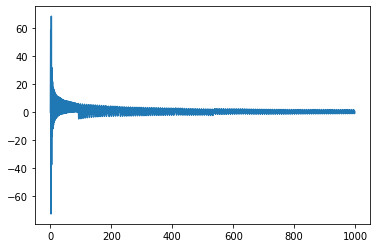

In [9]:
coefficients_0 = [row[0] for row in coefficients[0]]
plt.plot(coefficients_0)

In [8]:
print(coefficients)

[[array([[ 0.        ],
       [-0.03556248]]), array([[58.99563323],
       [27.45073835]]), array([[-72.90567438],
       [-40.46938566]]), array([[68.73061439],
       [34.05054067]]), array([[-37.57914215],
       [-21.00196648]]), array([[31.81142907],
       [15.22248032]]), array([[-17.14391927],
       [ -9.62085846]]), array([[21.74402809],
       [10.45444213]]), array([[-11.84470984],
       [ -6.39648624]]), array([[17.84150074],
       [ 8.83855537]]), array([[-9.22099989],
       [-4.66412802]]), array([[16.43020049],
       [ 8.20533493]]), array([[-7.27639636],
       [-3.59363728]]), array([[14.94311279],
       [ 7.51082699]]), array([[-6.02406493],
       [-2.89381381]]), array([[13.83341806],
       [ 7.00223704]]), array([[-5.09733297],
       [-2.3696524 ]]), array([[12.97861258],
       [ 6.61808364]]), array([[-4.37578552],
       [-1.95698401]]), array([[12.06700184],
       [ 6.13519079]]), array([[-3.88094812],
       [-1.72528064]]), array([[11.7108531 ],
  

In [ ]:
coefficients_1 = [row[1] for row in coefficients]
plt.plot(coefficients_1)

In [ ]:
gradients_0 = [row[0] for row in gradients]
plt.plot(gradients_0)

In [ ]:
gradients_1 = [row[1] for row in gradients]
plt.plot(gradients_1)